# Importing the used libraries and reading the data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
classes = ["Apparel","Footwear"]
def create_dataframe(paths):
    dfs = {}
    for path_name, path in paths.items():
        filepaths = []
        labels = []
        classlist = os.listdir(path)

        for lbl in classlist:
            if lbl == 'Apparel':
                label = 'Apparel'
            elif lbl == 'Footwear':
                label = 'Footwear'
            else:
                continue

            classpath = os.path.join(path, lbl)
            flist = os.listdir(classpath)

            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(label)

        df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
        dfs[path_name] = df

    return dfs
    # this function transforms the folder of images (eg: train data) to a data frame as it is easier to deal with

In [4]:
train_path = "/content/drive/MyDrive/slash_Data/Original_data/train"
test_path = "/content/drive/MyDrive/slash_Data/Original_data/test"
valid_path = "/content/drive/MyDrive/slash_Data/Original_data/validation"

paths = {'train': train_path, 'test': test_path, 'valid': valid_path}
dfs = create_dataframe(paths)

# Access the dataframes
train_df = dfs['train']
test_df = dfs['test']
valid_df = dfs['valid']

# Display lengths of dataframes
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

train_df length: 1815 test_df length: 576 valid_df length: 515


In [5]:
def specify_sample_number(df):
      classes=sorted(list(df['labels'].unique()))
      class_count = len(classes)
      print('The number of classes in the train dataset is: ', class_count)
      groups=df.groupby('labels')
      print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
      countlist=[]
      classlist=[]
      for label in sorted(list(df['labels'].unique())):
        group=groups.get_group(label)
        countlist.append(len(group))
        classlist.append(label)
        print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

      # get the classes with the minimum and maximum number of train images
      max_value=np.max(countlist)
      max_index=countlist.index(max_value)
      max_class=classlist[max_index]
      min_value=np.min(countlist)
      min_index=countlist.index(min_value)
      min_class=classlist[min_index]
      print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

In [6]:
specify_sample_number(train_df)

The number of classes in the train dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  850     
           Footwear                 965     
Footwear  has the most images=  965   Apparel  has the least images=  850


In [7]:
specify_sample_number(valid_df)

The number of classes in the train dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  210     
           Footwear                 305     
Footwear  has the most images=  305   Apparel  has the least images=  210


In [8]:
specify_sample_number(test_df)

The number of classes in the train dataset is:  2
            CLASS               IMAGE COUNT 
           Apparel                  266     
           Footwear                 310     
Footwear  has the most images=  310   Apparel  has the least images=  266


# Data preprocessing & preparation

In [9]:
# def balance(df, n, working_dir, img_size):
#     print('Initial length of dataframe is', len(df))
#     aug_dir = os.path.join(working_dir, 'aug')  # directory to store the augmented images
#     shutil.rmtree(aug_dir, ignore_errors=True)  # Remove existing directory with same name
#     os.makedirs(aug_dir)  # Create a new directory

#     # Create class directories within the aug directory
#     for label in df['labels'].unique():
#         os.makedirs(os.path.join(aug_dir, label))

#     total = 0
#     gen = ImageDataGenerator(
#         horizontal_flip=True,
#         rotation_range=20,
#         width_shift_range=.2,
#         height_shift_range=.2,
#         zoom_range=.2,
#         shear_range=0.2
#     )

#     groups = df.groupby('labels')  # Group by class
#     for label, group in groups:
#         sample_count = len(group)  # Number of samples in this class
#         if sample_count < n:
#             delta = n - sample_count  # Number of augmented images to create
#             target_dir = os.path.join(aug_dir, label)  # Directory to save the images
#             print(f"For class {label}, creating {delta} augmented images.")

#             aug_gen = gen.flow_from_dataframe(
#                 group,
#                 x_col='filepaths',
#                 y_col=None,
#                 target_size=img_size,
#                 class_mode=None,
#                 batch_size=1,
#                 shuffle=False,
#                 save_to_dir=target_dir,
#                 save_prefix='aug-',
#                 color_mode='rgb',
#                 save_format='jpg'
#             )

#             aug_img_count = 0
#             while aug_img_count < delta:
#                 images = next(aug_gen)
#                 aug_img_count += len(images)
#             total += aug_img_count

#     print('Total Augmented images created =', total)

#     # Create aug_df and merge with train_df
#     aug_df = pd.DataFrame(columns=['filepaths', 'labels'])
#     for root, dirs, files in os.walk(aug_dir):
#         for file in files:
#             fpath = os.path.join(root, file)
#             label = os.path.basename(root)
#             aug_df = aug_df.append({'filepaths': fpath, 'labels': label}, ignore_index=True)

#     df = pd.concat([df, aug_df]).reset_index(drop=True)
#     print('Length of augmented dataframe is now', len(df))
#     return df

In [10]:
# n = 950
# num = 300
# m = 250
# working_dir = '/content/drive/MyDrive/Slash/folder_of_trails'
# img_size = (224, 224)
# train_df = balance(train_df, n, working_dir, img_size)
# valid_df = balance(valid_df,num,working_dir,img_size)
# test_df = balance(test_df,m,working_dir,img_size)

In [11]:
def setup_data_generators(train_df, valid_df, test_df, img_size, batch_size=20):

        train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=20
        )


        t_and_v_datagen = ImageDataGenerator()


        train_gen = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )

        valid_gen = t_and_v_datagen.flow_from_dataframe(
            valid_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )


        length = len(test_df)
        test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
        test_steps = int(length / test_batch_size)

        test_gen = t_and_v_datagen.flow_from_dataframe(
            test_df,
            x_col='filepaths',
            y_col='labels',
            target_size=img_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=False,
            batch_size=test_batch_size
        )


        classes = list(train_gen.class_indices.keys())
        class_indices = list(train_gen.class_indices.values())
        class_count = len(classes)
        labels = test_gen.labels

        print('Test batch size:', test_batch_size, 'Test steps:', test_steps, 'Number of classes:', class_count)

        return train_gen, valid_gen, test_gen

In [12]:
train_gen, valid_gen, test_gen = setup_data_generators(train_df, valid_df, test_df, (224, 224), batch_size=20)

Found 1815 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.
Found 576 validated image filenames belonging to 2 classes.
Test batch size: 72 Test steps: 8 Number of classes: 2


In [13]:
def show_image_samples(gen):
    images, labels = next(gen)  # Get a sample batch from the generator
    print("Number of images:", len(images))
    print("Number of labels:", len(labels))

    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        class_name = 'Footwear' if labels[i] == 1 else 'Apparel'
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()



Number of images: 20
Number of labels: 20


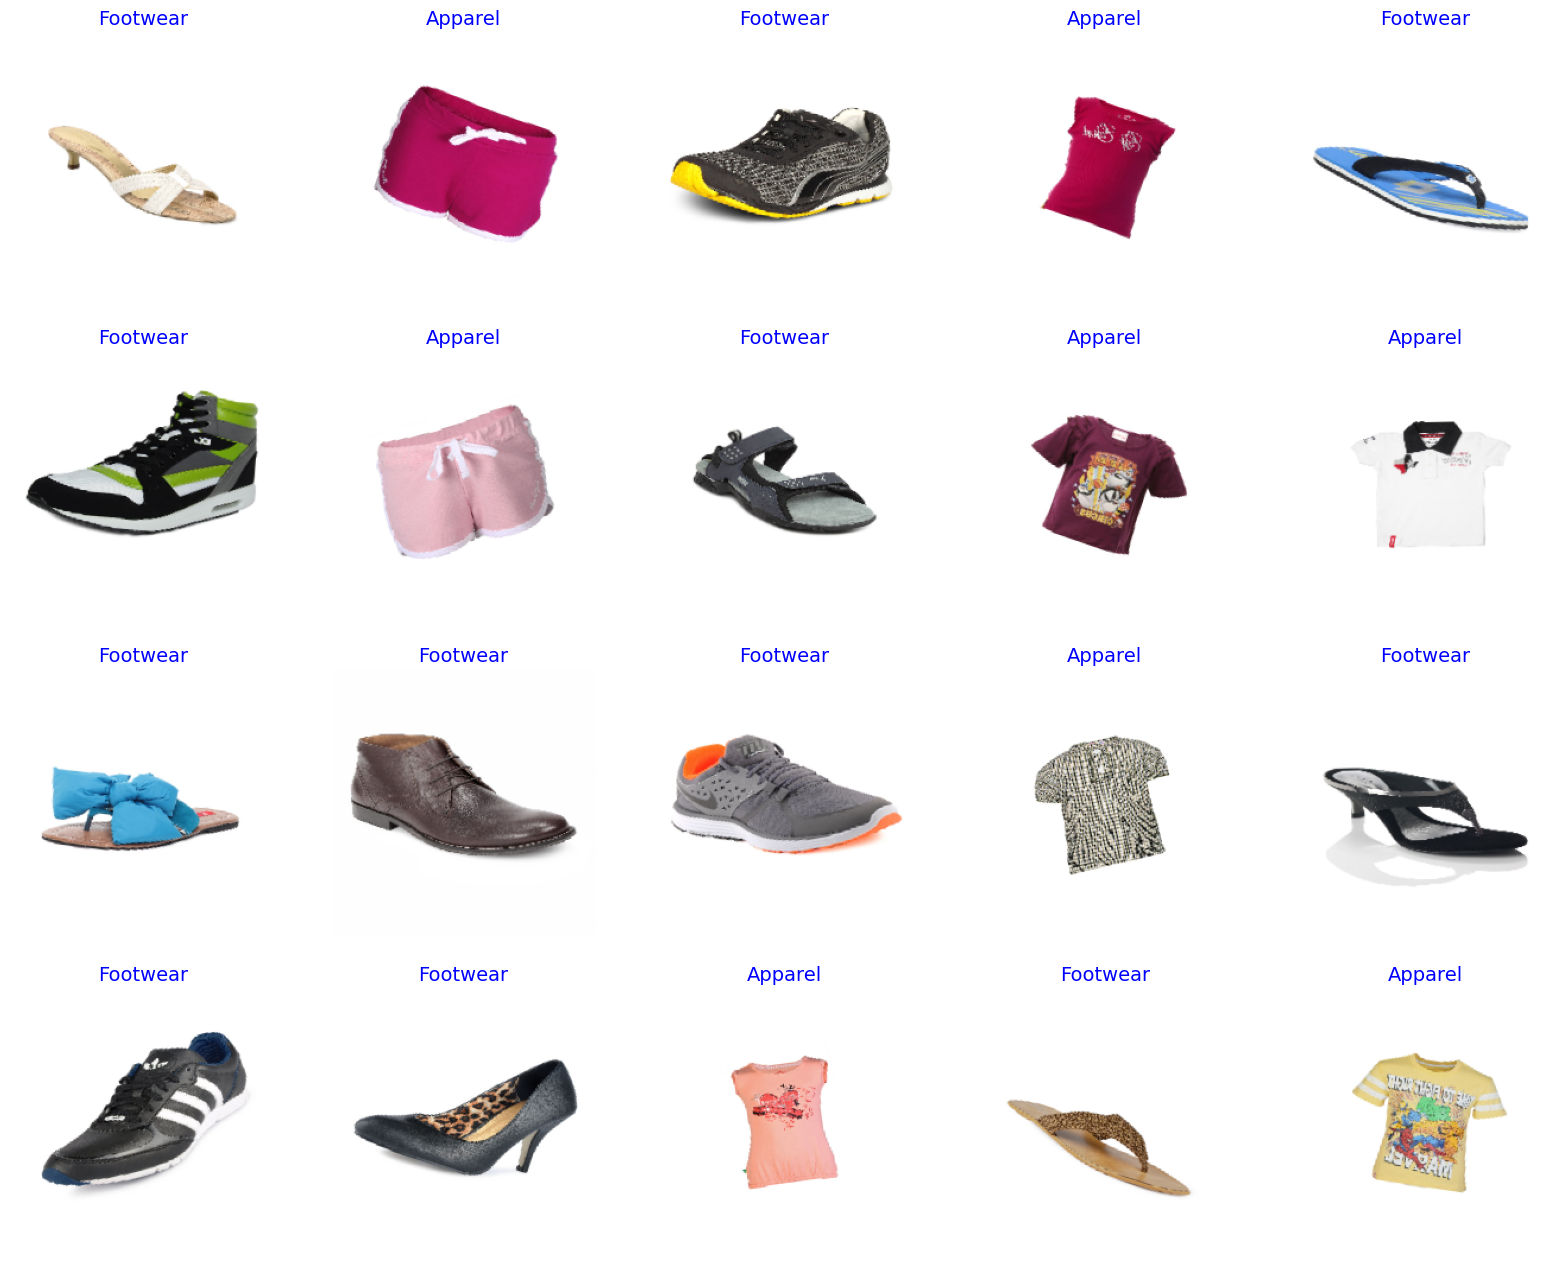

In [14]:
show_image_samples(train_gen)
# to show the augmentation effect

#Model Building

In [17]:
# transfer learning using mobile net
img_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
x = base_model.output
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
modell = Model(inputs=base_model.input, outputs=output)
lr = 0.01 # learning rate
modell.compile(Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
epochs = 16
history = modell.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,  # Already shuffled during the creation of train_gen
    initial_epoch=0,
)

Epoch 1/16
91/91 [==============================] - 120s 1s/step - loss: 6.9158 - accuracy: 0.8904 - val_loss: 4.9622 - val_accuracy: 0.5922
Epoch 2/16
91/91 [==============================] - 89s 984ms/step - loss: 2.6628 - accuracy: 0.9554 - val_loss: 2.5095 - val_accuracy: 0.4078
Epoch 3/16
91/91 [==============================] - 88s 972ms/step - loss: 1.5460 - accuracy: 0.9774 - val_loss: 3.5942 - val_accuracy: 0.5922
Epoch 4/16
91/91 [==============================] - 88s 970ms/step - loss: 0.9322 - accuracy: 0.9807 - val_loss: 1.3582 - val_accuracy: 0.5922
Epoch 5/16
91/91 [==============================] - 89s 979ms/step - loss: 0.5638 - accuracy: 0.9961 - val_loss: 1.3344 - val_accuracy: 0.5922
Epoch 6/16
91/91 [==============================] - 91s 995ms/step - loss: 0.3641 - accuracy: 0.9939 - val_loss: 0.9540 - val_accuracy: 0.5922
Epoch 7/16
91/91 [==============================] - 88s 974ms/step - loss: 0.2347 - accuracy: 0.9967 - val_loss: 1.6341 - val_accuracy: 0.5922
E

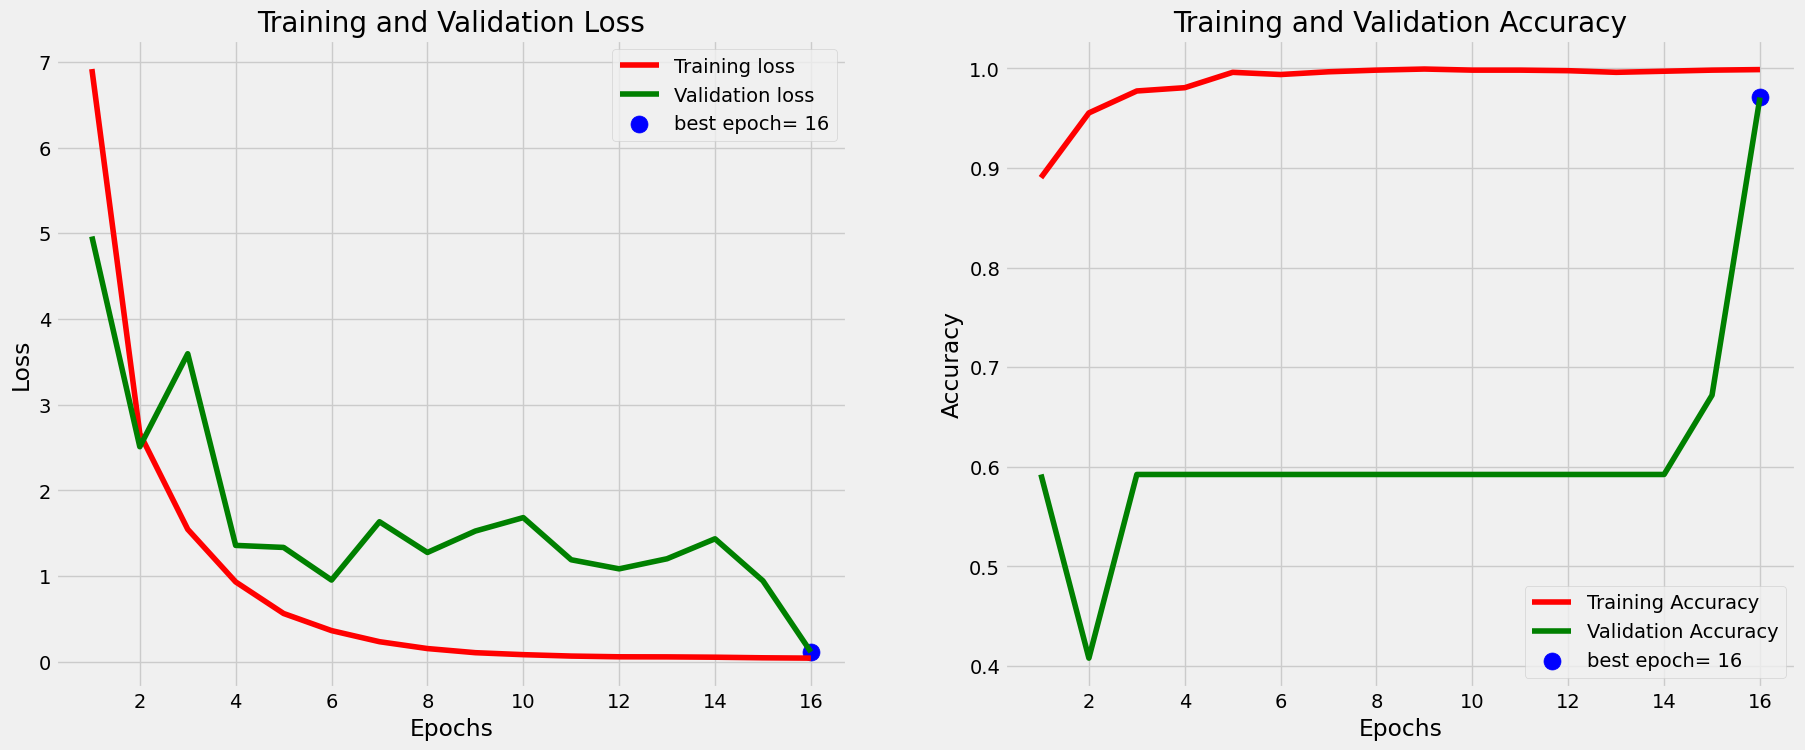

In [19]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()
tr_plot(history,0)

# Fine tuning

## Grid search

In [20]:
# # defining a function that builds the model to use it in the grid search loop to decide the best hyper-parameters we can use
# def build_model(learning_rate):
#     base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = True
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.4)(x)
#     output = Dense(1, activation='sigmoid')(x)

#     model = tf.keras.Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [21]:
# # we will use the grid search method to find the most suitable learnong rate and number of training epochs as both are hyper-parameters

# learning_rates = [0.001, 0.0001,0.00001]
# num_epochs_list = [10, 15, 20, 25]

# best_val_accuracy = 0
# best_learning_rate = None
# best_num_epochs = None

#
# for lr in learning_rates:
#     for num_epochs in num_epochs_list:
#         model = build_model(lr)
#         early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#         history = model.fit(train_gen, epochs=num_epochs, validation_data=valid_gen, verbose=1)
#         val_accuracy = model.evaluate(valid_gen, verbose=0)[1] # Evaluate model on validation set

#         # Print results
#         print(f"Learning rate: {lr}, Epochs: {num_epochs}, Validation accuracy: {val_accuracy}")

#         # Check if this combination improves validation accuracy
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             best_learning_rate = lr
#             best_num_epochs = num_epochs

# print(f"Best validation accuracy: {best_val_accuracy}")
# print(f"Best learning rate: {best_learning_rate}")
# print(f"Best number of epochs: {best_num_epochs}")

##Fine tuned MobileNetV2

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True  # from the epoch with the best whieghts
)

In [23]:
img_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True # here we set the model to be trainable to learn new features from the images provided at training
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x) # we added batch normalization to make the calculation less complex thus reduce overfitting as possible and improve generalization
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)   # we added a dropout as a regularization technique to reduce overfitting as possible
output = Dense(1, activation='sigmoid')(x) # the activation function of the output layer  is sigmoid function as we are doing a binary classification
tuned_model = Model(inputs=base_model.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) # to reduce the unnecesssary training epochs in addition to prevention overfitting
tuned_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
tuned_history=tuned_model.fit(x=train_gen,  epochs=20, verbose=1, validation_data=valid_gen,
                shuffle=False,  initial_epoch=0, callbacks=[early_stopping] )

Epoch 1/20
91/91 [==============================] - 124s 1s/step - loss: 5.3860 - accuracy: 0.9741 - val_loss: 4.1627 - val_accuracy: 0.9709
Epoch 2/20
91/91 [==============================] - 98s 1s/step - loss: 2.8188 - accuracy: 0.9961 - val_loss: 2.4099 - val_accuracy: 0.9456
Epoch 3/20
91/91 [==============================] - 88s 973ms/step - loss: 1.7347 - accuracy: 0.9939 - val_loss: 1.4904 - val_accuracy: 0.9806
Epoch 4/20
91/91 [==============================] - 99s 1s/step - loss: 1.1375 - accuracy: 0.9961 - val_loss: 0.9826 - val_accuracy: 0.9845
Epoch 5/20
91/91 [==============================] - 88s 971ms/step - loss: 0.7814 - accuracy: 0.9978 - val_loss: 0.6670 - val_accuracy: 0.9942
Epoch 6/20
91/91 [==============================] - 86s 951ms/step - loss: 0.5564 - accuracy: 0.9972 - val_loss: 0.4684 - val_accuracy: 0.9961
Epoch 7/20
91/91 [==============================] - 88s 969ms/step - loss: 0.4014 - accuracy: 1.0000 - val_loss: 0.3351 - val_accuracy: 0.9961
Epoch 8

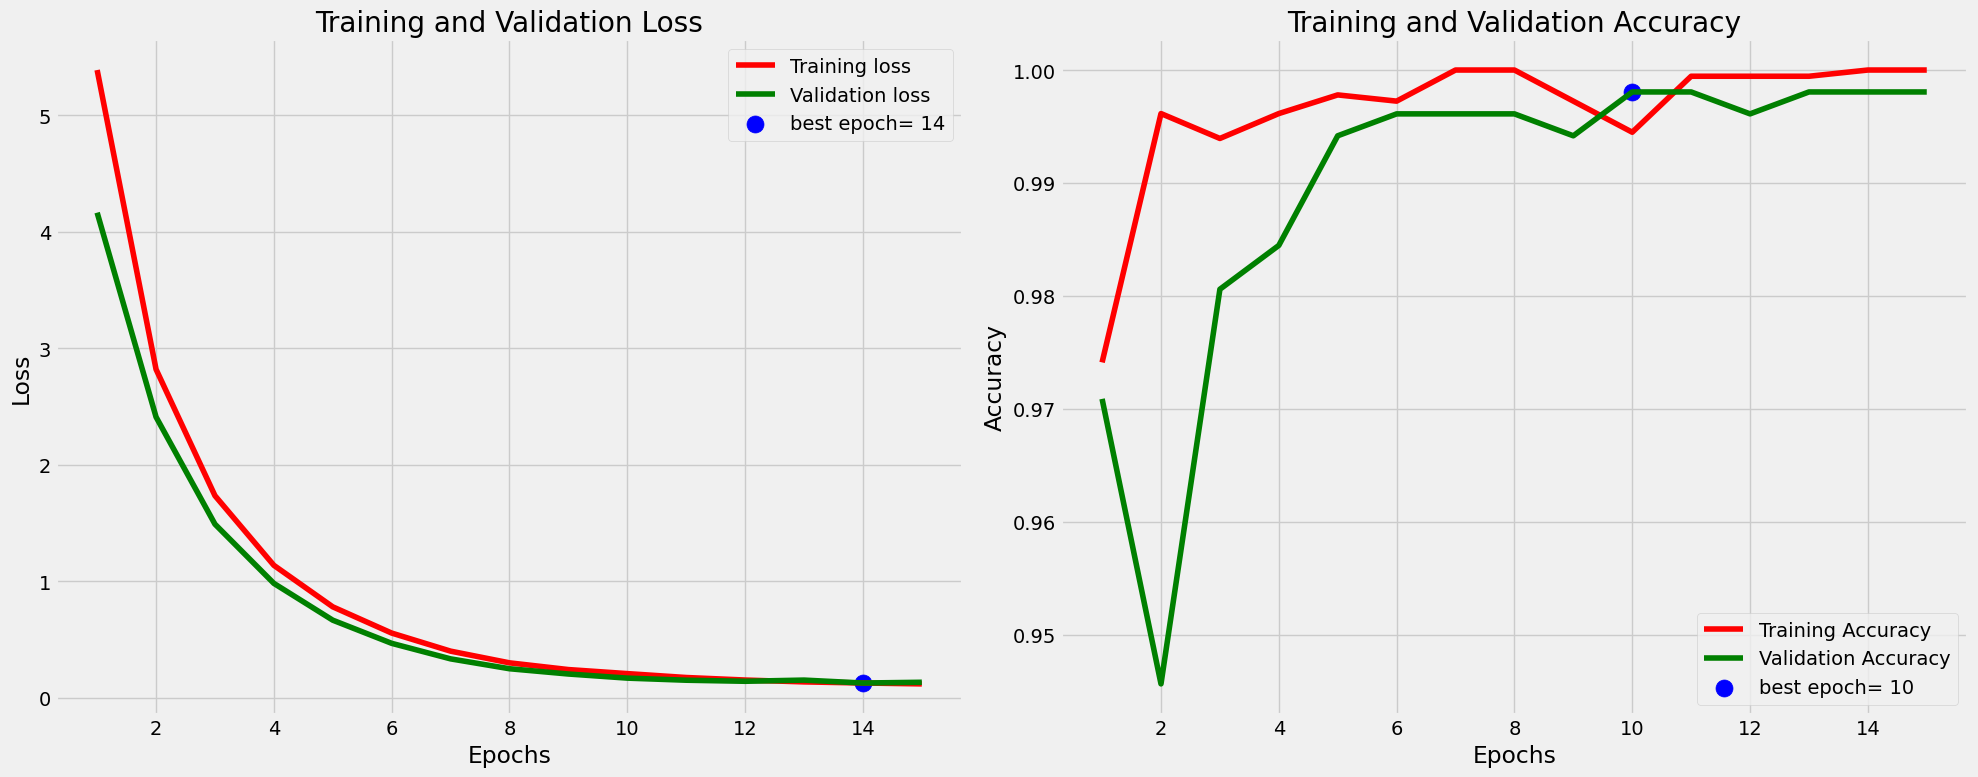

In [25]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()
tr_plot(tuned_history,0)

## comparing both regular and fine tuned models

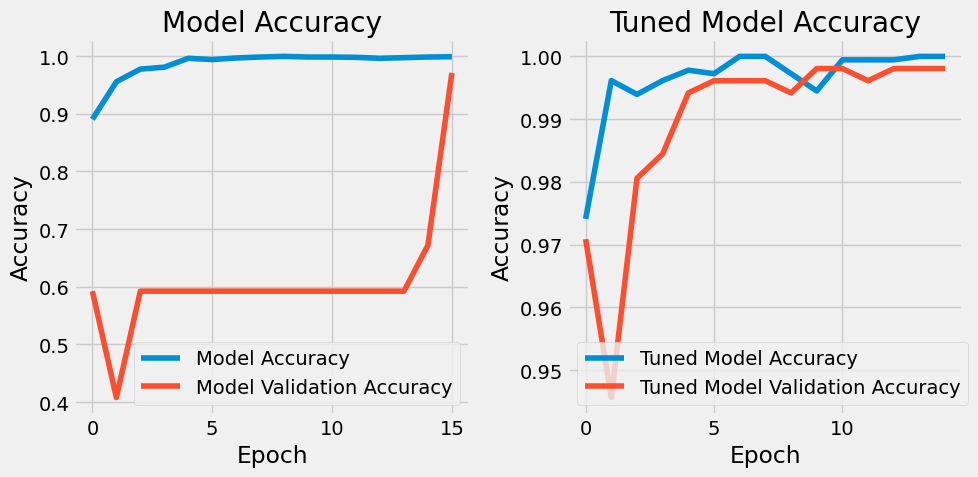

In [26]:
# Plot training and validation accuracy for the first model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model Accuracy')
plt.plot(history.history['val_accuracy'], label='Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training and validation accuracy for the second model
plt.subplot(1, 2, 2)
plt.plot(tuned_history.history['accuracy'], label='Tuned Model Accuracy')
plt.plot(tuned_history.history['val_accuracy'], label='Tuned Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Tuned Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# model testing

In [27]:
def predictor(model, test_gen, test_steps):
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())

    # Make predictions on the test data
    y_pred_probs = model.predict(test_gen, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f'Test Accuracy: {accuracy:.2f}')

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')

    # Generate classification report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return accuracy

##testing

In [30]:
test_loss, test_accuracy = tuned_model.evaluate(test_gen, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


8/8 [==============================] - 17s 2s/step - loss: 0.1750 - accuracy: 0.9965
Test Loss: 0.17502433061599731
Test Accuracy: 0.9965277910232544


# Saving the  model

In [37]:
tuned_model.save("/content/drive/MyDrive/slash_Data/Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load the model to use /fine-tune/ deploy

In [38]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/drive/MyDrive/slash_Data/Model.h5")